# MLFlow Example Notebook

## Repo: https://github.com
---

This notebook demonstrates an example of dataset preprocessing, ML model training and evaluation, model tuning via MLflow tracking and finally REST API model serving via MLflow models.

---
- **Dateset:** Bike Sharing Dataset: http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
- **Goal:** predict `rented_bikes` (count per hour) based on weather and time information.


**References:**
- https://docs.databricks.com/_static/notebooks/gbt-regression.html
- https://www.kaggle.com/pratsiuk/mlflow-experiment-automation-top-9
- https://mlflow.org/docs/latest/tracking.html

# Setup ML Flow Magics

### Load ML Flow Enviornment variable

In [91]:
%loadMlflow

Backend configured


### Set ML Flow Experiment Name

In [92]:
%Setexp --name bikesharetesting

INFO: 'bikesharetesting' does not exist. Creating a new experiment


# Install Required Libraries and Python Packages

In [93]:
#!export http_proxy=http://proxy:8080 
#!export https_proxy=http:/proxy:8080 
#!conda install -c anaconda graphviz
#!pip install --proxy http://proxy:8080 kfp==1.4.0 pydotplus

# Import Libraries

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.sklearn
from mlflow import log_metric, log_param, log_artifact

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.inspection import permutation_importance
from mlflow.models.signature import infer_signature
from sklearn import tree

from pydotplus import graph_from_dot_data
import graphviz
from IPython.display import Image

import itertools

plt.style.use("fivethirtyeight")
pd.plotting.register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

# Import Data

Dataset and explanation:
http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

- Input file: `hour.csv` - contains bike sharing counts aggregated on hourly basis. 
- Size: 17379 hours / rows


In [95]:
# download and extract csv files into Data folder
#!wget -nc "http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
#!unzip -o "Bike-Sharing-Dataset.zip"

In [96]:
# load input data into pandas dataframe
bike_sharing = pd.read_csv("hour.csv")
bike_sharing        

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


## Data preprocessing

In [97]:
# remove unused columns
bike_sharing.drop(columns=["instant", "dteday", "registered", "casual"], inplace=True)

# use better names
bike_sharing.rename(
    columns={
        "yr": "year",
        "mnth": "month",
        "hr": "hour_of_day",
        "holiday": "is_holiday",
        "workingday": "is_workingday",
        "weathersit": "weather_situation",
        "temp": "temperature",
        "atemp": "feels_like_temperature",
        "hum": "humidity",
        "cnt": "rented_bikes",
    },
    inplace=True,
)

# show samples
bike_sharing

,season,year,month,hour_of_day,is_holiday,weekday,is_workingday,weather_situation,temperature,feels_like_temperature,humidity,windspeed,rented_bikes
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61


### Data Visualization 

<AxesSubplot:title={'center':'Total rented bikes by hour of day'}, xlabel='hour_of_day'>

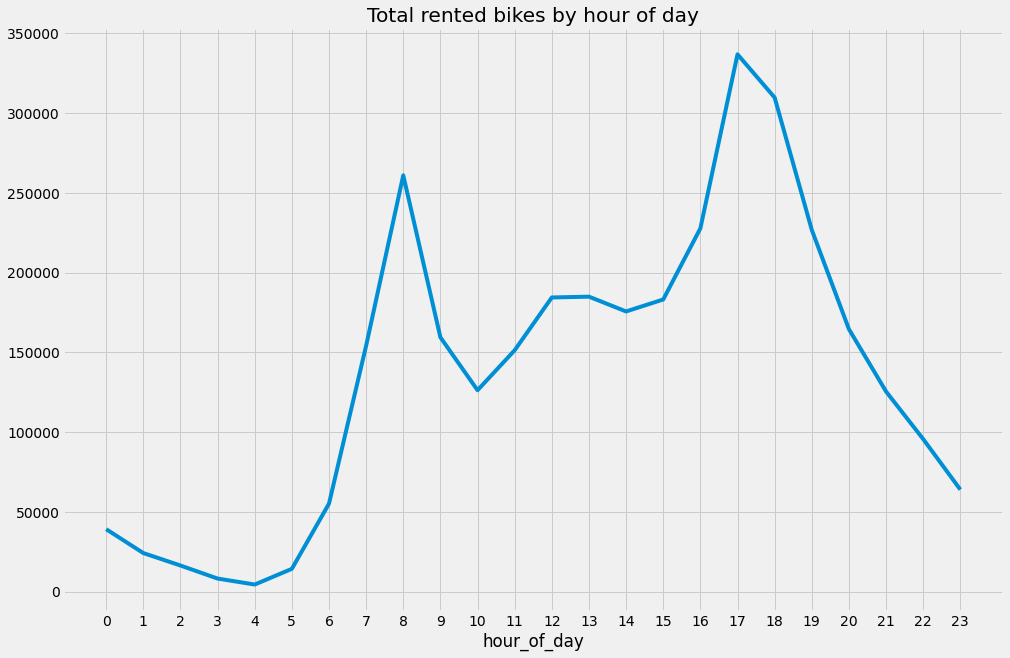

In [98]:
hour_of_day_agg = bike_sharing.groupby(["hour_of_day"])["rented_bikes"].sum()

hour_of_day_agg.plot(
    kind="line", 
    title="Total rented bikes by hour of day",
    xticks=hour_of_day_agg.index,
    figsize=(15, 10),
)

## Prepare training and test data sets


In [99]:
# Split the dataset randomly into 70% for training and 30% for testing.
X = bike_sharing.drop("rented_bikes", axis=1)
y = bike_sharing.rented_bikes
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=42)

print(f"Training samples: {X_train.size}")
print(f"Test samples: {X_test.size}")

Training samples: 145980
Test samples: 62568


# Evaluation Metrics

Create evaluation methods to be used in training stage (next step)

## Root Mean Square Error (RMSE)

References: 
- https://medium.com/@xaviergeerinck/artificial-intelligence-how-to-measure-performance-accuracy-precision-recall-f1-roc-rmse-611d10e4caac
- https://www.kaggle.com/residentmario/model-fit-metrics#Root-mean-squared-error-(RMSE)


In [100]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def rmse_score(y, y_pred):
    score = rmse(y, y_pred)
    print("RMSE score: {:.4f}".format(score))
    return score

### Cross-Validation RMSLE score

cross-validation combines (averages) measures of fitness in prediction to derive a more accurate estimate of model prediction performance.

Background: 
- https://en.wikipedia.org/wiki/Cross-validation_(statistics)
- https://www.kaggle.com/carlolepelaars/understanding-the-metric-rmsle


In [101]:
def rmsle_cv(model, X_train, y_train):
    kf = KFold(n_splits=3, shuffle=True, random_state=42).get_n_splits(X_train.values)
    # Evaluate a score by cross-validation
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse


def rmse_cv_score(model, X_train, y_train):
    score = rmsle_cv(model, X_train, y_train)
    print("Cross-Validation RMSE score: {:.4f} (std = {:.4f})".format(score.mean(), score.std()))
    return score

## Feature Importance

Background: https://medium.com/bigdatarepublic/feature-importance-whats-in-a-name-79532e59eea3

In [102]:
def model_feature_importance(model):
    feature_importance = pd.DataFrame(
        model.feature_importances_,
        index=X_train.columns,
        columns=["Importance"],
    )

    # sort by importance
    feature_importance.sort_values(by="Importance", ascending=False, inplace=True)

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=feature_importance.reset_index(),
        y="index",
        x="Importance",
    ).set_title("Feature Importance")
    # save image
    plt.savefig("model_artifacts/feature_importance.png", bbox_inches='tight')

## Permutation Importance

Background: https://www.kaggle.com/dansbecker/permutation-importance

In [103]:
def model_permutation_importance(model):
    p_importance = permutation_importance(model, X_test, y_test, random_state=42, n_jobs=-1)

    # sort by importance
    sorted_idx = p_importance.importances_mean.argsort()[::-1]
    p_importance = pd.DataFrame(
        data=p_importance.importances[sorted_idx].T,
        columns=X_train.columns[sorted_idx]
    )

    # plot
    plt.figure(figsize=(12, 8))
    sns.barplot(
        data=p_importance,
        orient="h"
    ).set_title("Permutation Importance")

    # save image
    plt.savefig("model_artifacts/permutation_importance.png", bbox_inches="tight")

## Decision Tree Visualization

Reference: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc 


TODO: plot all trees

In [104]:
def model_tree_visualization(model):
    # generate visualization
    tree_dot_data = tree.export_graphviz(
        decision_tree=model.estimators_[0, 0],  # Get the first tree,
        label="all",
        feature_names=X_train.columns,
        filled=True,
        rounded=True,
        proportion=True,
        impurity=False,
        precision=1,
    )

    # save image
    graph_from_dot_data(tree_dot_data).write_png("model_artifacts/Decision_Tree_Visualization.png")

    # show tree
    return graphviz.Source(tree_dot_data)

# MLflow Tracking

Reference: https://www.mlflow.org/docs/latest/cli.html#mlflow-ui


## MLflow Logger

In [106]:
# Track params and metrics
def log_mlflow_run(model, signature):
    # Auto-logging for scikit-learn estimators
    # mlflow.sklearn.autolog()

    # log estimator_name name
    name = model.__class__.__name__
    mlflow.set_tag("estimator_name", name)

    # log input features
    mlflow.set_tag("features", str(X_train.columns.values.tolist()))

    # Log tracked parameters only
    mlflow.log_params({key: model.get_params()[key] for key in parameters})

    mlflow.log_metrics({
        'RMSE_CV': score_cv.mean(),
        'RMSE': score,
    })

    # log training loss
    for s in model.train_score_:
        mlflow.log_metric("Train Loss", s)

    # Save model to artifacts
    mlflow.sklearn.log_model(model, "model", signature=signature)

    # log charts
    mlflow.log_artifacts("model_artifacts")

    # misc
    # Log all model parameters
    mlflow.log_params(model.get_params())
    mlflow.log_param("Training size", X_test.size)
    mlflow.log_param("Test size", y_test.size)

# Model Training


## Model Type & Method

For this example,
- Approache: Decision tree (Supervised learning)
- Tree type: Regression tree
- Technique/ensemble method: Gradient boosting

**All put together we get:** [GBRT (Gradient Boosted Regression Tree)](https://orbi.uliege.be/bitstream/2268/163521/1/slides.pdf)

Background:
- Choosing a model: https://scikit-learn.org/stable/tutorial/machine_learning_map
- Machine Learning Models Explained
: https://docs.paperspace.com/machine-learning/wiki/machine-learning-models-explained
- Gradient Boosted Regression Trees: https://orbi.uliege.be/bitstream/2268/163521/1/slides.pdf


In [107]:
# GBRT (Gradient Boosted Regression Tree) scikit-learn implementation 
model_class = GradientBoostingRegressor

## Model Hyper-parameters 


In [108]:
parameters = {
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [4, 5, 6],
    # "verbose": True,
}

### Tuning the hyper-parameters: Grid search

- Simple but inefficient
- more advanced tuning techniques: https://research.fb.com/efficient-tuning-of-online-systems-using-bayesian-optimization/

In [110]:
# generate parameters combinations
params_keys = parameters.keys()
params_values = [
    parameters[key] if isinstance(parameters[key], list) else [parameters[key]]
    for key in params_keys
]
runs_parameters = [
    dict(zip(params_keys, combination)) for combination in itertools.product(*params_values)
]

## Training runs

In [111]:
# training loop
for i, run_parameters in enumerate(runs_parameters):
    print(f"Run {i}: {run_parameters}")

    # mlflow: stop active runs if any
    if mlflow.active_run():
        mlflow.end_run()
    # mlflow:track run
    mlflow.start_run(run_name=f"Run {i}")

    # create model instance
    model = model_class(**run_parameters)

    # train
    model.fit(X_train, y_train)

    # get evaluations scores
    score = rmse_score(y_test, model.predict(X_test))
    score_cv = rmse_cv_score(model, X_train, y_train)
    
    # generate charts
    model_feature_importance(model)
    plt.close()
    model_permutation_importance(model)
    plt.close()
    model_tree_visualization(model)

    # get model signature
    signature = infer_signature(model_input=X_train, model_output=model.predict(X_train))

    # mlflow: log metrics
    log_mlflow_run(model, signature)

    # mlflow: end tracking
    mlflow.end_run()
    print("")

Run 0: {'learning_rate': 0.1, 'max_depth': 4}
RMSE score: 52.0019
Cross-Validation RMSE score: 56.5502 (std = 0.1427)

Run 1: {'learning_rate': 0.1, 'max_depth': 5}
RMSE score: 44.6961
Cross-Validation RMSE score: 48.1914 (std = 0.1712)

Run 2: {'learning_rate': 0.1, 'max_depth': 6}
RMSE score: 41.8623
Cross-Validation RMSE score: 44.9797 (std = 0.4243)

Run 3: {'learning_rate': 0.05, 'max_depth': 4}
RMSE score: 63.1557
Cross-Validation RMSE score: 67.8193 (std = 1.7241)

Run 4: {'learning_rate': 0.05, 'max_depth': 5}
RMSE score: 53.0504
Cross-Validation RMSE score: 55.9904 (std = 0.8639)

Run 5: {'learning_rate': 0.05, 'max_depth': 6}
RMSE score: 46.2968
Cross-Validation RMSE score: 49.8090 (std = 0.5420)

Run 6: {'learning_rate': 0.01, 'max_depth': 4}
RMSE score: 120.1656
Cross-Validation RMSE score: 123.9446 (std = 1.0540)

Run 7: {'learning_rate': 0.01, 'max_depth': 5}
RMSE score: 112.4922
Cross-Validation RMSE score: 116.0879 (std = 0.9958)

Run 8: {'learning_rate': 0.01, 'max_dep

# Best Model Results

In [112]:
best_run_df = mlflow.search_runs(order_by=['metrics.RMSE_CV ASC'], max_results=1)
if len(best_run_df.index) == 0:
    raise Exception(f"Found no runs for experiment '{experiment_name}'")

best_run = mlflow.get_run(best_run_df.at[0, 'run_id'])
best_model_uri = f"{best_run.info.artifact_uri}/model"
best_model = mlflow.sklearn.load_model(best_model_uri)

In [113]:
# print best run info
print("Best run info:")
print(f"Run id: {best_run.info.run_id}")
print(f"Run parameters: {best_run.data.params}")
print("Run score: RMSE_CV = {:.4f}".format(best_run.data.metrics['RMSE_CV']))
print(f"Run model URI: {best_model_uri}")

Best run info:
Run id: d52a00c543e94d26a37994a517fce096
Run parameters: {'min_impurity_decrease': '0.0', 'verbose': '0', 'random_state': 'None', 'min_samples_leaf': '1', 'max_features': 'None', 'n_iter_no_change': 'None', 'Training size': '62568', 'ccp_alpha': '0.0', 'Test size': '5214', 'init': 'None', 'min_weight_fraction_leaf': '0.0', 'criterion': 'friedman_mse', 'tol': '0.0001', 'validation_fraction': '0.1', 'min_samples_split': '2', 'max_depth': '6', 'warm_start': 'False', 'max_leaf_nodes': 'None', 'learning_rate': '0.1', 'n_estimators': '100', 'alpha': '0.9', 'presort': 'deprecated', 'loss': 'ls', 'min_impurity_split': 'None', 'subsample': '1.0'}
Run score: RMSE_CV = 44.9797
Run model URI: s3://mlflow/10/d52a00c543e94d26a37994a517fce096/artifacts/model


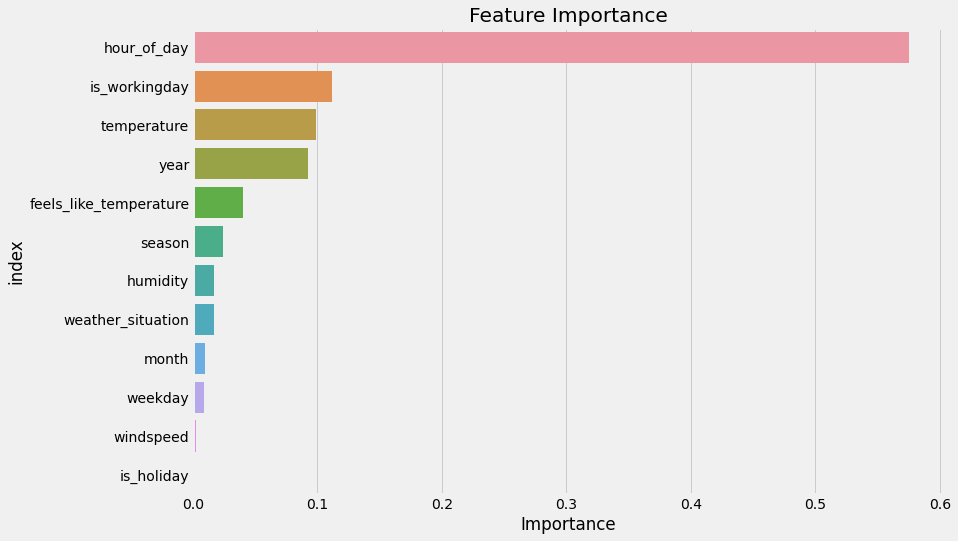

In [114]:
model_feature_importance(best_model)

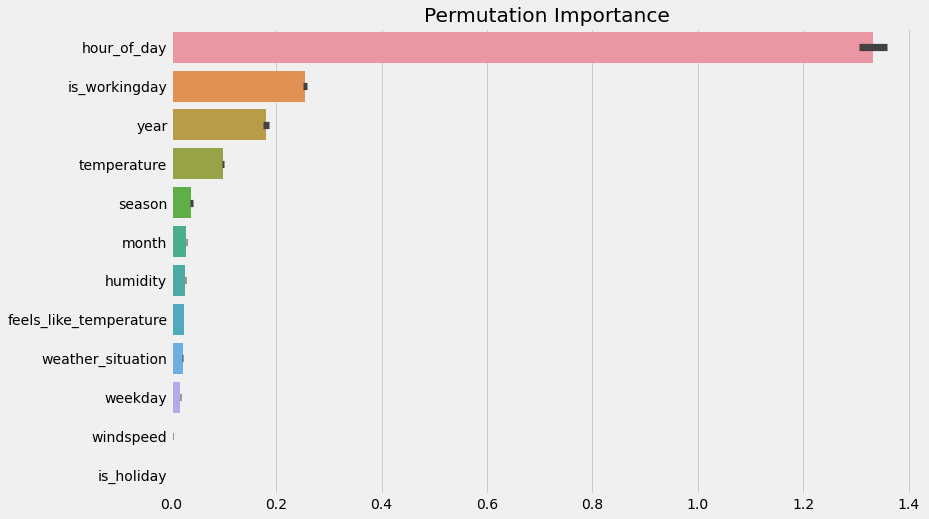

In [115]:
model_permutation_importance(best_model)

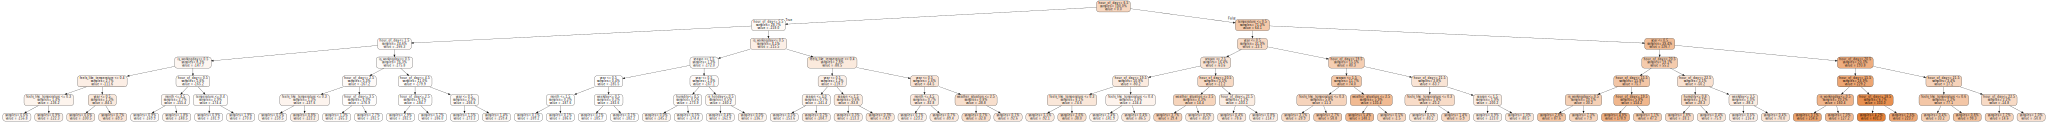

In [116]:
model_tree_visualization(best_model)

# Inference

In [117]:
test_predictions = X_test.copy()
# real output (rented_bikes) from test dataset
test_predictions["rented_bikes"] = y_test

# add "predicted_rented_bikes" from test dataset
test_predictions["predicted_rented_bikes"] = best_model.predict(X_test).astype(int)

# show results
test_predictions

,season,year,month,hour_of_day,is_holiday,weekday,is_workingday,weather_situation,temperature,feels_like_temperature,humidity,windspeed,rented_bikes,predicted_rented_bikes
12830,3,1,6,19,0,6,0,1,0.80,0.6970,0.27,0.1940,425,397
8688,1,1,1,20,1,1,0,1,0.24,0.2273,0.41,0.2239,88,99
7091,4,0,10,2,0,5,1,1,0.32,0.3030,0.66,0.2836,4,13
12230,2,1,5,19,0,2,1,1,0.78,0.7121,0.52,0.3582,526,564
431,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881,13,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12749,2,1,6,10,0,3,1,1,0.82,0.7727,0.52,0.1343,167,182
11476,2,1,4,9,0,6,0,2,0.38,0.3939,0.37,0.0000,214,241
12847,3,1,6,12,0,0,0,1,0.80,0.6970,0.33,0.2239,556,555
16721,4,1,12,12,0,2,1,1,0.52,0.5000,0.68,0.1940,312,297


<AxesSubplot:title={'center':'Rented bikes vs predicted rented bikes'}, xlabel='rented_bikes', ylabel='predicted_rented_bikes'>

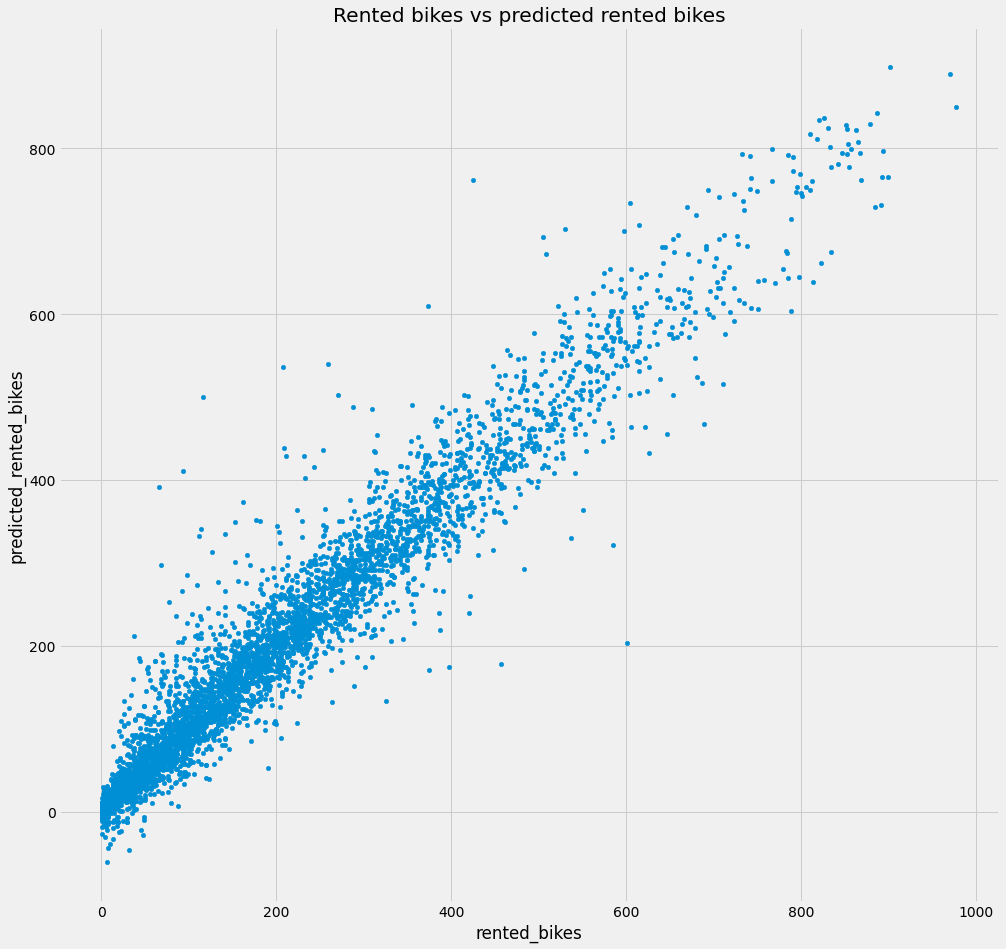

In [118]:
# plot truth vs prediction values
test_predictions.plot(
    kind="scatter",
    x="rented_bikes",
    y="predicted_rented_bikes",
    title="Rented bikes vs predicted rented bikes",
    figsize=(15, 15),
)

# Model Serving

Reference: https://www.mlflow.org/docs/latest/models.html

## Create Secret For Accessing Saved Model From MLFlow Minio in Namespace Where We Are Going To Deploy Seldon Depeployment

In [ ]:
%%bash
cat <<EOF | kubectl apply -f -
apiVersion: v1
kind: Secret
metadata:
  name: seldon-init-container-secret
type: Opaque
stringData:
  AWS_ACCESS_KEY_ID: admin # Minio ACCESS KEY
  AWS_SECRET_ACCESS_KEY: admin123 # Minio Secret Key
  AWS_ENDPOINT_URL: http://minio:10032 # Minio Endpoint
  USE_SSL: "false"
EOF

### Create KFP Client Object

In [120]:
import kfp
import json
import kfp.dsl as dsl


import requests, kfp

endpoint = "http://kubeflow:10029/pipeline" # Kubeflow Url
api_username  = "***" # Username
api_password = "***" # Password


def get_user_auth_session_cookie(url, username, password):
    url = url.replace('/pipeline', '')
    get_response = requests.get(url)
    if 'auth' in get_response.url:
        credentials = {'login': username, 'password': password}
        # Authenticate user
        session = requests.Session()
        session.post(get_response.url, data=credentials)
        cookie_auth_key = 'authservice_session'
        cookie_auth_value = session.cookies.get(cookie_auth_key)
        if cookie_auth_value:
            return cookie_auth_key + '=' + cookie_auth_value

session_cookie = get_user_auth_session_cookie(endpoint,api_username,api_password)
client = kfp.Client(host=endpoint,cookies=session_cookie)

### K8s Resource JSON For Seldon Deployment and passing best_model_uri 

In [ ]:
#Namespace Name 
NAMESPACE="st01"

DEPLOYMENT = {
  "apiVersion": "machinelearning.seldon.io/v1alpha3",
  "kind": "SeldonDeployment",
  "metadata": {
    "name": "bikesharing",
    "namespace": NAMESPACE
  },
  "spec": {
    "name": "bikesharing",
    "predictors": [
      {
        "graph": {
          "children": [],
          "implementation": "MLFLOW_SERVER",
          "modelUri": best_model_uri,
          "name": "bikesharing",
          "envSecretRefName": "seldon-init-container-secret"
        },
        "name": "bikesharing",
        "replicas": 1,
        "svcOrchSpec": {
          "resources": {
            "limits": {
              "cpu": "1"
            },
            "requests": {
              "cpu": "0.5"
            }
          }
        },
        "componentSpecs": [
          {
            "spec": {
              "containers": [
                {
                  "resources": {
                    "limits": {
                      "cpu": "1"
                    },
                    "requests": {
                      "cpu": "0.5"
                    }
                  },
                  "env": [
                    {
                      "name": "https_proxy",
                      "value": "proxy:8080"
                    },
                    {
                      "name": "http_proxy",
                      "value": "proxy:8080"
                    }
                  ],
                  "name": "bikesharing",
                  "livenessProbe": {
                    "initialDelaySeconds": 80,
                    "failureThreshold": 200,
                    "periodSeconds": 5,
                    "successThreshold": 1,
                    "httpGet": {
                      "path": "/health/ping",
                      "port": "http",
                      "scheme": "HTTP"
                    }
                  },
                  "readinessProbe": {
                    "initialDelaySeconds": 80,
                    "failureThreshold": 200,
                    "periodSeconds": 5,
                    "successThreshold": 1,
                    "httpGet": {
                      "path": "/health/ping",
                      "port": "http",
                      "scheme": "HTTP"
                    }
                  }
                }
              ]
            }
          }
        ]
      }
    ]
  }
}

DEPLOYMENT = json.dumps(DEPLOYMENT)

## Submiting KFP Pipeline Which Will Deploy Trained Model Through Seldon Deployment

In [122]:
@dsl.pipeline(
    name="Deploy Model",
    description="Deploy Trained Model Using Seldon"
)
def deploy_model():
    
    # Deploy mlflow model.
    op_seldondeployment = dsl.ResourceOp(
        name='seldon-deployment',
        k8s_resource=json.loads(DEPLOYMENT),
        action='create'
    )
    
    
client.create_run_from_pipeline_func(
    deploy_model,
    experiment_name="Seldon Deployment",
    arguments={},
)

RunPipelineResult(run_id=c1ffea86-2738-423a-a420-1f52de9846bf)

## Prediction

In [125]:
import requests, json

KUBEFLOW_URL = endpoint.replace('/pipeline', '')
SELDON_DEPLOYMENT_NAME="bikesharing"

headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json'
}

cookies = {
    'authservice_session': session_cookie.replace('authservice_session=', '')
}

json_request= json.dumps({"data":{"ndarray": [[1, 0, 1, 0, 0, 6, 0, 1, 0.24, 0.2879, 0.81, 0.0000]]}})

URL = "{}/seldon/{}/{}/api/v1.0/predictions".format(KUBEFLOW_URL,NAMESPACE,SELDON_DEPLOYMENT_NAME)

response = requests.post(URL, headers=headers, cookies=cookies, data=json_request)
print(response.text)

{"data":{"names":[],"ndarray":[35.616200948055564]},"meta":{}}

